In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

# Configuración de dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo: {device}')

Dispositivo: cuda


In [2]:
# %% [markdown]
# ## 1. Descarga y submuestreo de datos
# %% [code]
# Parámetros globales
DATA_ROOT = 'data'
NUM_CLASSES = 10
SAMPLES_PER_CLASS = 150
BATCH_SIZE = 64
IMG_SIZE = 128

# Descargar dataset completo
base_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

full_train = datasets.STL10(
    root=DATA_ROOT,
    split='train',
    download=True,
    transform=base_transform
)

# Submuestreo estratificado
indices = {i: [] for i in range(NUM_CLASSES)}
for idx, (_, label) in enumerate(full_train):
    if len(indices[label]) < SAMPLES_PER_CLASS:
        indices[label].append(idx)

selected_indices = np.concatenate([indices[i] for i in range(NUM_CLASSES)])
np.random.shuffle(selected_indices)

100%|██████████| 2.64G/2.64G [09:56<00:00, 4.42MB/s]


In [ ]:
# %% [markdown]
# ## 2. Transformaciones personalizadas
# %% [code]
class Preprocessor:
    def __init__(self, apply_filters=False, apply_clahe=False):
        self.apply_filters = apply_filters
        self.apply_clahe = apply_clahe
        if apply_clahe:
            self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    def __call__(self, img_pil):
        img_np = np.array(img_pil)

        # Aplicar filtros primero
        if self.apply_filters:
            img_np = cv2.GaussianBlur(img_np, (5, 5), 0)
            img_np = cv2.medianBlur(img_np, 3)
            img_np = cv2.bilateralFilter(img_np, 7, 75, 75)

        # Luego CLAHE si está activado
        if self.apply_clahe:
            gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
            enhanced = self.clahe.apply(gray)
            img_np = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)

        return Image.fromarray(img_np)

# Función para crear transformaciones
def create_transforms(apply_filters=False, apply_clahe=False):
    return transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        Preprocessor(apply_filters, apply_clahe),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

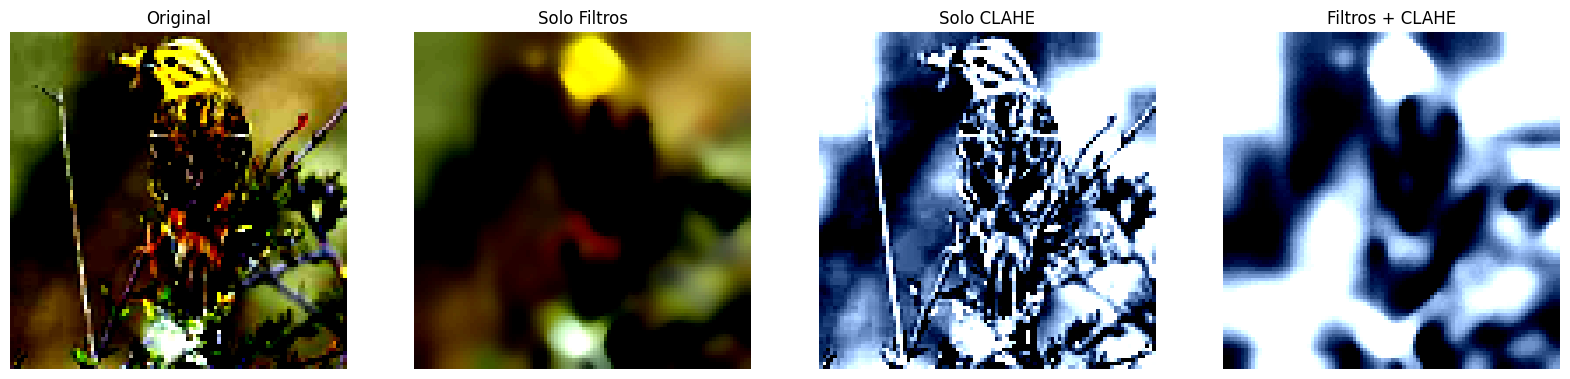

In [ ]:
# %% [markdown]
# ## 3. Carga de datos y visualización
# %% [code]
# Función para visualizar preprocesado
def visualize_preprocessing(dataset, idx=0):
    img_raw = dataset[idx][0]  # Imagen ya transformada en tensor
    img_raw_np = img_raw.permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    configs = [
        ('Original', False, False),
        ('Solo Filtros', True, False),
        ('Solo CLAHE', False, True),
        ('Filtros + CLAHE', True, True)
    ]

    for i, (title, use_filters, use_clahe) in enumerate(configs):
        transform = create_transforms(use_filters, use_clahe)
        # Forzar transformación directamente desde el objeto PIL para consistencia
        img_pil = full_train[idx][0]
        img_tensor = transform(img_pil)
        img_np = img_tensor.permute(1, 2, 0).numpy()
        axs[i].imshow(img_np)
        axs[i].set_title(title)
        axs[i].axis('off')

    plt.suptitle("Comparación de Preprocesamientos", fontsize=16)
    plt.tight_layout()
    plt.show()


In [ ]:
# %% [markdown]
# ## 4. Configuración del modelo
# %% [code]
def create_model(freeze_layers=True):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    if freeze_layers:
        for param in model.parameters():
            param.requires_grad = False

        # Descongelar últimas capas
        for param in model.layer4.parameters():
            param.requires_grad = True

    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    return model.to(device)

In [ ]:
# %% [markdown]
# ## 5. Entrenamiento y evaluación
# %% [code]
def train_model(train_loader, val_loader, experiment_name, epochs=25):
    model = create_model()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0
    history = {'train_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        # Validación
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        scheduler.step(epoch_loss)
        history['train_loss'].append(epoch_loss)
        history['val_acc'].append(epoch_acc)

        print(f'{experiment_name} - Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), f'best_{experiment_name}.pth')

    return history

In [ ]:
# %% [markdown]
# ## 6. Pipeline de experimentación
# %% [code]
# Configuraciones de experimentos
experiments = {
    'baseline': {'filters': False, 'clahe': False},
    'filtros': {'filters': True, 'clahe': False},
    'clahe': {'filters': False, 'clahe': True},
    'completo': {'filters': True, 'clahe': True}
}

# División train/val (80/20)
split_idx = int(0.8 * len(selected_indices))
train_indices = selected_indices[:split_idx]
val_indices = selected_indices[split_idx:]

results = {}

for exp_name, config in experiments.items():
    print(f'\n=== Entrenando {exp_name.upper()} ===')

    # Crear DataLoaders
    transform = create_transforms(config['filters'], config['clahe'])

    dataset = datasets.STL10(
        root=DATA_ROOT,
        split='train',
        transform=transform
    )

    train_loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        sampler=SubsetRandomSampler(train_indices),
        num_workers=2
    )

    val_loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        sampler=SubsetRandomSampler(val_indices),
        num_workers=2
    )

    # Entrenamiento
    history = train_model(train_loader, val_loader, exp_name)
    results[exp_name] = history



=== Entrenando BASELINE ===


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s]
Epoch 1: 100%|██████████| 19/19 [00:02<00:00,  8.50it/s]


baseline - Epoch 1: Loss: 0.3799, Acc: 0.7433


Epoch 2: 100%|██████████| 19/19 [00:00<00:00, 19.92it/s]


baseline - Epoch 2: Loss: 0.1141, Acc: 0.7633


Epoch 3: 100%|██████████| 19/19 [00:00<00:00, 19.66it/s]


baseline - Epoch 3: Loss: 0.0482, Acc: 0.7900


Epoch 4: 100%|██████████| 19/19 [00:00<00:00, 19.76it/s]


baseline - Epoch 4: Loss: 0.0230, Acc: 0.7933


Epoch 5: 100%|██████████| 19/19 [00:00<00:00, 19.16it/s]


baseline - Epoch 5: Loss: 0.0122, Acc: 0.8200


Epoch 6: 100%|██████████| 19/19 [00:00<00:00, 19.51it/s]


baseline - Epoch 6: Loss: 0.0074, Acc: 0.8200


Epoch 7: 100%|██████████| 19/19 [00:01<00:00, 17.40it/s]


baseline - Epoch 7: Loss: 0.0053, Acc: 0.8233


Epoch 8: 100%|██████████| 19/19 [00:01<00:00, 12.51it/s]


baseline - Epoch 8: Loss: 0.0041, Acc: 0.8233


Epoch 9: 100%|██████████| 19/19 [00:00<00:00, 19.41it/s]


baseline - Epoch 9: Loss: 0.0033, Acc: 0.8200


Epoch 10: 100%|██████████| 19/19 [00:00<00:00, 20.47it/s]


baseline - Epoch 10: Loss: 0.0027, Acc: 0.8133


Epoch 11: 100%|██████████| 19/19 [00:00<00:00, 19.64it/s]


baseline - Epoch 11: Loss: 0.0024, Acc: 0.8267


Epoch 12: 100%|██████████| 19/19 [00:00<00:00, 20.06it/s]


baseline - Epoch 12: Loss: 0.0019, Acc: 0.8300


Epoch 13: 100%|██████████| 19/19 [00:00<00:00, 19.95it/s]


baseline - Epoch 13: Loss: 0.0015, Acc: 0.8267


Epoch 14: 100%|██████████| 19/19 [00:00<00:00, 20.43it/s]


baseline - Epoch 14: Loss: 0.0015, Acc: 0.8167


Epoch 15: 100%|██████████| 19/19 [00:01<00:00, 14.13it/s]


baseline - Epoch 15: Loss: 0.0012, Acc: 0.8233


Epoch 16: 100%|██████████| 19/19 [00:01<00:00, 10.83it/s]


baseline - Epoch 16: Loss: 0.0013, Acc: 0.8067


Epoch 17: 100%|██████████| 19/19 [00:01<00:00, 15.27it/s]


baseline - Epoch 17: Loss: 0.0012, Acc: 0.8200


Epoch 18: 100%|██████████| 19/19 [00:00<00:00, 19.67it/s]


baseline - Epoch 18: Loss: 0.0010, Acc: 0.8133


Epoch 19: 100%|██████████| 19/19 [00:00<00:00, 19.56it/s]


baseline - Epoch 19: Loss: 0.0009, Acc: 0.8233


Epoch 20: 100%|██████████| 19/19 [00:00<00:00, 20.05it/s]


baseline - Epoch 20: Loss: 0.0008, Acc: 0.8167


Epoch 21: 100%|██████████| 19/19 [00:00<00:00, 19.07it/s]


baseline - Epoch 21: Loss: 0.0008, Acc: 0.8267


Epoch 22: 100%|██████████| 19/19 [00:00<00:00, 19.20it/s]


baseline - Epoch 22: Loss: 0.0007, Acc: 0.8200


Epoch 23: 100%|██████████| 19/19 [00:00<00:00, 19.57it/s]


baseline - Epoch 23: Loss: 0.0007, Acc: 0.8267


Epoch 24: 100%|██████████| 19/19 [00:00<00:00, 19.72it/s]


baseline - Epoch 24: Loss: 0.0007, Acc: 0.8267


Epoch 25: 100%|██████████| 19/19 [00:01<00:00, 12.56it/s]


baseline - Epoch 25: Loss: 0.0006, Acc: 0.8167

=== Entrenando FILTROS ===


Epoch 1: 100%|██████████| 19/19 [00:03<00:00,  6.32it/s]


filtros - Epoch 1: Loss: 0.4135, Acc: 0.5300


Epoch 2: 100%|██████████| 19/19 [00:05<00:00,  3.62it/s]


filtros - Epoch 2: Loss: 0.1445, Acc: 0.6067


Epoch 3: 100%|██████████| 19/19 [00:02<00:00,  6.34it/s]


filtros - Epoch 3: Loss: 0.0652, Acc: 0.6233


Epoch 4: 100%|██████████| 19/19 [00:02<00:00,  6.40it/s]


filtros - Epoch 4: Loss: 0.0326, Acc: 0.6367


Epoch 5: 100%|██████████| 19/19 [00:03<00:00,  5.05it/s]


filtros - Epoch 5: Loss: 0.0177, Acc: 0.6467


Epoch 6: 100%|██████████| 19/19 [00:03<00:00,  6.28it/s]


filtros - Epoch 6: Loss: 0.0109, Acc: 0.6367


Epoch 7: 100%|██████████| 19/19 [00:03<00:00,  6.19it/s]


filtros - Epoch 7: Loss: 0.0078, Acc: 0.6500


Epoch 8: 100%|██████████| 19/19 [00:03<00:00,  5.09it/s]


filtros - Epoch 8: Loss: 0.0054, Acc: 0.6600


Epoch 9: 100%|██████████| 19/19 [00:02<00:00,  6.36it/s]


filtros - Epoch 9: Loss: 0.0044, Acc: 0.6633


Epoch 10: 100%|██████████| 19/19 [00:03<00:00,  6.25it/s]


filtros - Epoch 10: Loss: 0.0035, Acc: 0.6633


Epoch 11: 100%|██████████| 19/19 [00:03<00:00,  5.05it/s]


filtros - Epoch 11: Loss: 0.0032, Acc: 0.6567


Epoch 12: 100%|██████████| 19/19 [00:02<00:00,  6.42it/s]


filtros - Epoch 12: Loss: 0.0026, Acc: 0.6567


Epoch 13: 100%|██████████| 19/19 [00:02<00:00,  6.45it/s]


filtros - Epoch 13: Loss: 0.0021, Acc: 0.6600


Epoch 14: 100%|██████████| 19/19 [00:03<00:00,  4.87it/s]


filtros - Epoch 14: Loss: 0.0019, Acc: 0.6667


Epoch 15: 100%|██████████| 19/19 [00:03<00:00,  6.28it/s]


filtros - Epoch 15: Loss: 0.0017, Acc: 0.6600


Epoch 16: 100%|██████████| 19/19 [00:03<00:00,  6.33it/s]


filtros - Epoch 16: Loss: 0.0017, Acc: 0.6667


Epoch 17: 100%|██████████| 19/19 [00:04<00:00,  4.68it/s]


filtros - Epoch 17: Loss: 0.0013, Acc: 0.6733


Epoch 18: 100%|██████████| 19/19 [00:02<00:00,  6.34it/s]


filtros - Epoch 18: Loss: 0.0012, Acc: 0.6667


Epoch 19: 100%|██████████| 19/19 [00:03<00:00,  6.31it/s]


filtros - Epoch 19: Loss: 0.0011, Acc: 0.6733


Epoch 20: 100%|██████████| 19/19 [00:03<00:00,  4.78it/s]


filtros - Epoch 20: Loss: 0.0010, Acc: 0.6800


Epoch 21: 100%|██████████| 19/19 [00:02<00:00,  6.35it/s]


filtros - Epoch 21: Loss: 0.0009, Acc: 0.6700


Epoch 22: 100%|██████████| 19/19 [00:03<00:00,  6.10it/s]


filtros - Epoch 22: Loss: 0.0008, Acc: 0.6633


Epoch 23: 100%|██████████| 19/19 [00:03<00:00,  4.81it/s]


filtros - Epoch 23: Loss: 0.0008, Acc: 0.6667


Epoch 24: 100%|██████████| 19/19 [00:02<00:00,  6.40it/s]


filtros - Epoch 24: Loss: 0.0007, Acc: 0.6667


Epoch 25: 100%|██████████| 19/19 [00:02<00:00,  6.37it/s]


filtros - Epoch 25: Loss: 0.0006, Acc: 0.6633

=== Entrenando CLAHE ===


Epoch 1: 100%|██████████| 19/19 [00:01<00:00, 16.96it/s]


clahe - Epoch 1: Loss: 0.4147, Acc: 0.5633


Epoch 2: 100%|██████████| 19/19 [00:01<00:00, 17.17it/s]


clahe - Epoch 2: Loss: 0.1381, Acc: 0.6433


Epoch 3: 100%|██████████| 19/19 [00:01<00:00, 16.99it/s]


clahe - Epoch 3: Loss: 0.0614, Acc: 0.7000


Epoch 4: 100%|██████████| 19/19 [00:01<00:00, 16.96it/s]


clahe - Epoch 4: Loss: 0.0309, Acc: 0.7033


Epoch 5: 100%|██████████| 19/19 [00:01<00:00, 11.27it/s]


clahe - Epoch 5: Loss: 0.0150, Acc: 0.6967


Epoch 6: 100%|██████████| 19/19 [00:01<00:00, 13.98it/s]


clahe - Epoch 6: Loss: 0.0098, Acc: 0.7067


Epoch 7: 100%|██████████| 19/19 [00:01<00:00, 16.97it/s]


clahe - Epoch 7: Loss: 0.0067, Acc: 0.7133


Epoch 8: 100%|██████████| 19/19 [00:01<00:00, 17.20it/s]


clahe - Epoch 8: Loss: 0.0054, Acc: 0.7067


Epoch 9: 100%|██████████| 19/19 [00:01<00:00, 17.29it/s]


clahe - Epoch 9: Loss: 0.0039, Acc: 0.7167


Epoch 10: 100%|██████████| 19/19 [00:01<00:00, 16.96it/s]


clahe - Epoch 10: Loss: 0.0032, Acc: 0.7100


Epoch 11: 100%|██████████| 19/19 [00:01<00:00, 16.63it/s]


clahe - Epoch 11: Loss: 0.0028, Acc: 0.7067


Epoch 12: 100%|██████████| 19/19 [00:01<00:00, 17.09it/s]


clahe - Epoch 12: Loss: 0.0021, Acc: 0.7100


Epoch 13: 100%|██████████| 19/19 [00:01<00:00, 11.21it/s]


clahe - Epoch 13: Loss: 0.0019, Acc: 0.7067


Epoch 14: 100%|██████████| 19/19 [00:01<00:00, 15.79it/s]


clahe - Epoch 14: Loss: 0.0017, Acc: 0.7067


Epoch 15: 100%|██████████| 19/19 [00:01<00:00, 17.57it/s]


clahe - Epoch 15: Loss: 0.0014, Acc: 0.7167


Epoch 16: 100%|██████████| 19/19 [00:01<00:00, 17.38it/s]


clahe - Epoch 16: Loss: 0.0014, Acc: 0.7133


Epoch 17: 100%|██████████| 19/19 [00:01<00:00, 17.39it/s]


clahe - Epoch 17: Loss: 0.0013, Acc: 0.7000


Epoch 18: 100%|██████████| 19/19 [00:01<00:00, 17.32it/s]


clahe - Epoch 18: Loss: 0.0010, Acc: 0.7167


Epoch 19: 100%|██████████| 19/19 [00:01<00:00, 17.40it/s]


clahe - Epoch 19: Loss: 0.0010, Acc: 0.7267


Epoch 20: 100%|██████████| 19/19 [00:01<00:00, 17.33it/s]


clahe - Epoch 20: Loss: 0.0008, Acc: 0.7267


Epoch 21: 100%|██████████| 19/19 [00:01<00:00, 10.93it/s]


clahe - Epoch 21: Loss: 0.0009, Acc: 0.7200


Epoch 22: 100%|██████████| 19/19 [00:01<00:00, 14.03it/s]


clahe - Epoch 22: Loss: 0.0008, Acc: 0.7133


Epoch 23: 100%|██████████| 19/19 [00:01<00:00, 17.16it/s]


clahe - Epoch 23: Loss: 0.0008, Acc: 0.7067


Epoch 24: 100%|██████████| 19/19 [00:01<00:00, 17.42it/s]


clahe - Epoch 24: Loss: 0.0006, Acc: 0.7267


Epoch 25: 100%|██████████| 19/19 [00:01<00:00, 17.16it/s]


clahe - Epoch 25: Loss: 0.0007, Acc: 0.7200

=== Entrenando COMPLETO ===


Epoch 1: 100%|██████████| 19/19 [00:03<00:00,  5.48it/s]


completo - Epoch 1: Loss: 0.4890, Acc: 0.3767


Epoch 2: 100%|██████████| 19/19 [00:03<00:00,  6.06it/s]


completo - Epoch 2: Loss: 0.1887, Acc: 0.4900


Epoch 3: 100%|██████████| 19/19 [00:03<00:00,  5.74it/s]


completo - Epoch 3: Loss: 0.0938, Acc: 0.5000


Epoch 4: 100%|██████████| 19/19 [00:03<00:00,  5.90it/s]


completo - Epoch 4: Loss: 0.0472, Acc: 0.5300


Epoch 5: 100%|██████████| 19/19 [00:03<00:00,  6.14it/s]


completo - Epoch 5: Loss: 0.0262, Acc: 0.5400


Epoch 6: 100%|██████████| 19/19 [00:03<00:00,  5.10it/s]


completo - Epoch 6: Loss: 0.0151, Acc: 0.5300


Epoch 7: 100%|██████████| 19/19 [00:03<00:00,  6.11it/s]


completo - Epoch 7: Loss: 0.0105, Acc: 0.5400


Epoch 8: 100%|██████████| 19/19 [00:03<00:00,  6.16it/s]


completo - Epoch 8: Loss: 0.0074, Acc: 0.5333


Epoch 9: 100%|██████████| 19/19 [00:03<00:00,  5.03it/s]


completo - Epoch 9: Loss: 0.0055, Acc: 0.5367


Epoch 10: 100%|██████████| 19/19 [00:03<00:00,  6.15it/s]


completo - Epoch 10: Loss: 0.0048, Acc: 0.5400


Epoch 11: 100%|██████████| 19/19 [00:03<00:00,  6.19it/s]


completo - Epoch 11: Loss: 0.0036, Acc: 0.5367


Epoch 12: 100%|██████████| 19/19 [00:03<00:00,  4.94it/s]


completo - Epoch 12: Loss: 0.0033, Acc: 0.5333


Epoch 13: 100%|██████████| 19/19 [00:03<00:00,  6.03it/s]


completo - Epoch 13: Loss: 0.0030, Acc: 0.5367


Epoch 14: 100%|██████████| 19/19 [00:03<00:00,  6.08it/s]


completo - Epoch 14: Loss: 0.0026, Acc: 0.5433


Epoch 15: 100%|██████████| 19/19 [00:04<00:00,  4.61it/s]


completo - Epoch 15: Loss: 0.0021, Acc: 0.5400


Epoch 16: 100%|██████████| 19/19 [00:03<00:00,  6.07it/s]


completo - Epoch 16: Loss: 0.0021, Acc: 0.5367


Epoch 17: 100%|██████████| 19/19 [00:03<00:00,  6.11it/s]


completo - Epoch 17: Loss: 0.0019, Acc: 0.5267


Epoch 18: 100%|██████████| 19/19 [00:04<00:00,  4.55it/s]


completo - Epoch 18: Loss: 0.0016, Acc: 0.5400


Epoch 19: 100%|██████████| 19/19 [00:03<00:00,  6.07it/s]


completo - Epoch 19: Loss: 0.0014, Acc: 0.5367


Epoch 20: 100%|██████████| 19/19 [00:03<00:00,  6.07it/s]


completo - Epoch 20: Loss: 0.0013, Acc: 0.5400


Epoch 21: 100%|██████████| 19/19 [00:04<00:00,  4.53it/s]


completo - Epoch 21: Loss: 0.0012, Acc: 0.5400


Epoch 22: 100%|██████████| 19/19 [00:03<00:00,  6.07it/s]


completo - Epoch 22: Loss: 0.0011, Acc: 0.5400


Epoch 23: 100%|██████████| 19/19 [00:03<00:00,  6.05it/s]


completo - Epoch 23: Loss: 0.0011, Acc: 0.5333


Epoch 24: 100%|██████████| 19/19 [00:04<00:00,  4.50it/s]


completo - Epoch 24: Loss: 0.0010, Acc: 0.5367


Epoch 25: 100%|██████████| 19/19 [00:03<00:00,  6.13it/s]


completo - Epoch 25: Loss: 0.0009, Acc: 0.5367


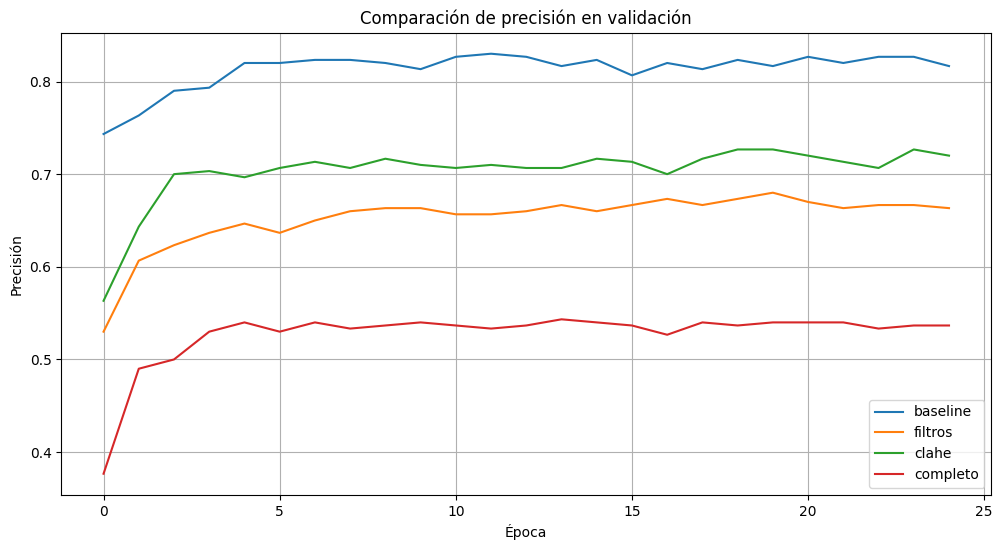


=== Resultados finales para BASELINE ===
              precision    recall  f1-score   support

    airplane       0.89      0.88      0.88       800
        bird       0.91      0.83      0.87       800
         car       0.92      0.90      0.91       800
         cat       0.69      0.79      0.74       800
        deer       0.79      0.81      0.80       800
         dog       0.73      0.64      0.68       800
       horse       0.78      0.82      0.80       800
      monkey       0.84      0.77      0.80       800
        ship       0.85      0.94      0.89       800
       truck       0.85      0.85      0.85       800

    accuracy                           0.82      8000
   macro avg       0.83      0.82      0.82      8000
weighted avg       0.83      0.82      0.82      8000



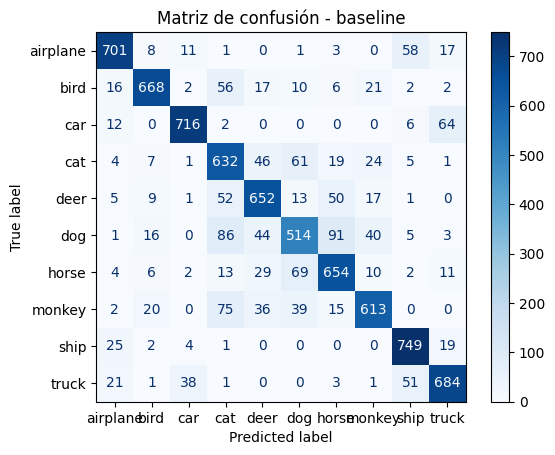


=== Resultados finales para FILTROS ===
              precision    recall  f1-score   support

    airplane       0.50      0.94      0.66       800
        bird       0.82      0.65      0.73       800
         car       0.91      0.70      0.79       800
         cat       0.45      0.69      0.55       800
        deer       0.65      0.61      0.63       800
         dog       0.67      0.51      0.58       800
       horse       0.66      0.75      0.70       800
      monkey       0.68      0.50      0.57       800
        ship       0.84      0.49      0.62       800
       truck       0.78      0.70      0.74       800

    accuracy                           0.65      8000
   macro avg       0.70      0.65      0.66      8000
weighted avg       0.70      0.65      0.66      8000



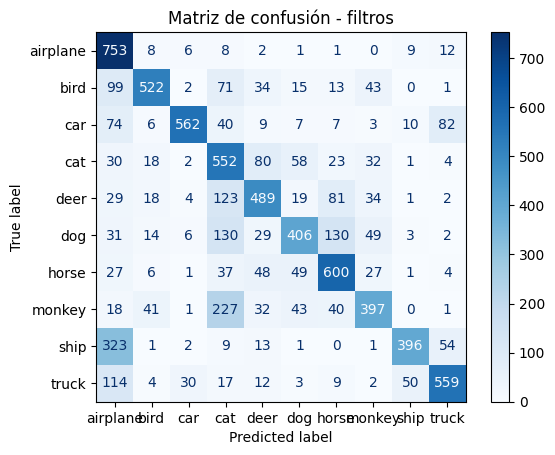


=== Resultados finales para CLAHE ===
              precision    recall  f1-score   support

    airplane       0.15      0.77      0.26       800
        bird       0.16      0.23      0.19       800
         car       0.71      0.12      0.20       800
         cat       0.15      0.21      0.18       800
        deer       0.45      0.13      0.20       800
         dog       0.23      0.11      0.15       800
       horse       0.49      0.04      0.08       800
      monkey       0.31      0.02      0.04       800
        ship       0.42      0.23      0.30       800
       truck       0.23      0.12      0.16       800

    accuracy                           0.20      8000
   macro avg       0.33      0.20      0.17      8000
weighted avg       0.33      0.20      0.17      8000



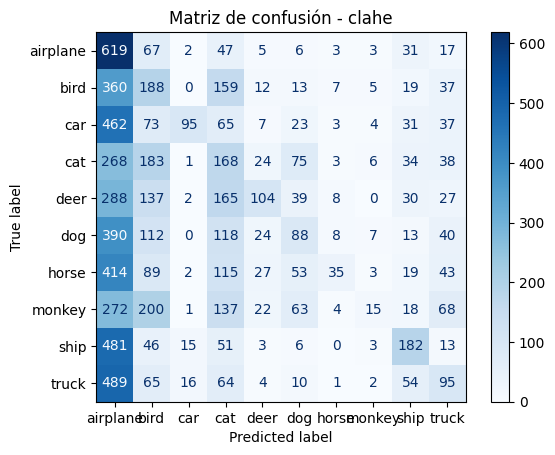


=== Resultados finales para COMPLETO ===
              precision    recall  f1-score   support

    airplane       0.16      0.55      0.25       800
        bird       0.15      0.52      0.23       800
         car       0.41      0.12      0.18       800
         cat       0.14      0.12      0.13       800
        deer       0.18      0.06      0.09       800
         dog       0.14      0.19      0.16       800
       horse       0.85      0.01      0.03       800
      monkey       0.00      0.00      0.00       800
        ship       0.37      0.06      0.10       800
       truck       0.44      0.03      0.05       800

    accuracy                           0.16      8000
   macro avg       0.28      0.16      0.12      8000
weighted avg       0.28      0.16      0.12      8000



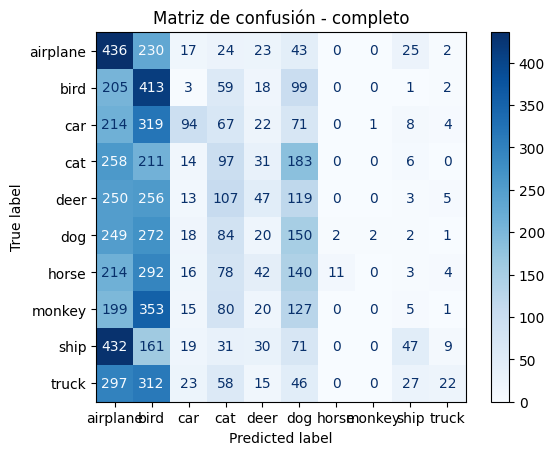

In [ ]:
# %% [markdown]
# ## 7. Visualización de resultados
# %% [code]
# Gráfico de comparación
plt.figure(figsize=(12, 6))
for exp_name, history in results.items():
    plt.plot(history['val_acc'], label=exp_name)
plt.title('Comparación de precisión en validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

# Reporte final de métricas
test_set = datasets.STL10(root=DATA_ROOT, split='test', transform=create_transforms(False, False))

for exp_name in experiments:
    model = create_model()
    model.load_state_dict(torch.load(f'best_{exp_name}.pth'))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_set:
            inputs = inputs.unsqueeze(0).to(device)
            outputs = model(inputs)
            pred = torch.argmax(outputs).item()
            all_preds.append(pred)
            all_labels.append(labels)

    print(f'\n=== Resultados finales para {exp_name.upper()} ===')
    print(classification_report(all_labels, all_preds, target_names=test_set.classes))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_set.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Matriz de confusión - {exp_name}')
    plt.show()